<a href="https://colab.research.google.com/github/Gmahajan189/Customer-Segmentation/blob/main/Venture_Creed_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import scipy.stats as stats



###Data Preprocessing


In [ ]:
# Load datasets
propensity_data = pd.read_feather("Propensity_Data.ftr")
sf_master = pd.read_feather("sf_master.ftr")

In [2]:
# Display basic dataset information
print("Propensity Data Info")
print(propensity_data.info())
print("\nSF Master Data Info")
print(sf_master.info())

Propensity Data Info
<class 'pandas.core.frame.DataFrame'>
Index: 3680 entries, 0 to 3679
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Customer_ID                    3680 non-null   int64 
 1   Account_Status                 3680 non-null   object
 2   Is_National_Account            3680 non-null   object
 3   Is_Washington                  3680 non-null   object
 4   Is_Tribal                      3680 non-null   object
 5   Is_VLT                         3680 non-null   object
 6   State_Code                     3372 non-null   object
 7   Postal_Code                    3680 non-null   object
 8   Country                        3680 non-null   object
 9   Jurisdiction_Name              3680 non-null   object
 10  CBSA                           3680 non-null   object
 11  Seasonality_Segment            2507 non-null   object
 12  Max_Quarter_Year_1             3680 non-null  

In [3]:
# Display first few rows of each dataset
print("\n Sample Rows: Propensity Data")
print(propensity_data.head())

print("\n Sample Rows: SF Master Data")
print(sf_master.head())


 Sample Rows: Propensity Data
   Customer_ID Account_Status Is_National_Account Is_Washington Is_Tribal  \
0            1         Active               False         False     False   
1            2         Active               False         False     False   
2            3         Active               False         False     False   
3            4         Active               False         False     False   
4            5         Active               False         False     False   

  Is_VLT State_Code Postal_Code Country Jurisdiction_Name  ... Revenue_Bucket  \
0  False         ON     L5N 2W8     CAN    AGCO - Ontario  ...           None   
1   True         LA       70053     USA              None  ...           None   
2   True         LA       70068     USA              None  ...           None   
3  False         NV       89521     USA              None  ...           None   
4  False         NV       89431     USA              None  ...           None   

  Profit_Bucket Mar

In [2]:
# Merge datasets on common key (i.e Customer_ID)
merged_df = propensity_data.merge(sf_master, on="Customer_ID", how="left")

# Check missing values after merging
print(merged_df.isnull().sum())

Customer_ID                         0
Account_Status                      0
Is_National_Account                 0
Is_Washington                       0
Is_Tribal                           0
Is_VLT                              0
State_Code                        328
Postal_Code                         0
Country                             0
Jurisdiction_Name                   0
CBSA                                0
Seasonality_Segment              2133
Max_Quarter_Year_1                  0
Max_Quarter_Year_2                  0
EA_Segment                       1446
Revenue_Bucket                      0
Profit_Bucket                       0
Market_Share_Segment                0
Casino_Size_Segment                 0
Market_Potential_Segment            0
Churn_Segment                       0
Competitiveness_Flag                0
Volume_Segment                      0
Density_Segment                  2487
Parent_Influence_Slots_Bucket     179
object_type                      2590
object_statu

In [3]:
# Check missing values count
missing_values = merged_df.isnull().sum()
missing_percentage = (missing_values / len(merged_df)) * 100

# Display missing values summary
missing_summary = pd.DataFrame({"Missing Count": missing_values, "Missing %": missing_percentage})
print("Missing Values Summary (Merged Dataset):")
print(missing_summary[missing_summary["Missing Count"] > 0].sort_values(by="Missing %", ascending=False))

Missing Values Summary (Merged Dataset):
                               Missing Count  Missing %
item_quantity                           2644  21.736271
object_type                             2590  21.292338
object_status                           2590  21.292338
sent_to_socp_date                       2590  21.292338
Density_Segment                         2487  20.445577
Seasonality_Segment                     2133  17.535350
EA_Segment                              1446  11.887537
State_Code                               328   2.696481
Parent_Influence_Slots_Bucket            179   1.471555


In [4]:
# Create missing value indicators
merged_df["Missing_Seasonality"] = merged_df["Seasonality_Segment"].isnull()
merged_df["Missing_EA"] = merged_df["EA_Segment"].isnull()

# Group by Revenue_Bucket to check missing value distribution
missing_revenue_analysis = merged_df.groupby("Revenue_Bucket")[["Missing_Seasonality", "Missing_EA"]].mean()
print("\nMissing Values Distribution by Revenue Bucket:")
print(missing_revenue_analysis)

# Group by Churn_Segment to check missing value distribution
missing_churn_analysis = merged_df.groupby("Churn_Segment")[["Missing_Seasonality", "Missing_EA"]].mean()
print("\nMissing Values Distribution by Churn Segment:")
print(missing_churn_analysis)


Missing Values Distribution by Revenue Bucket:
                Missing_Seasonality  Missing_EA
Revenue_Bucket                                 
H                          0.000445    0.019128
L                          0.302005    0.227130
M                          0.072203    0.169267
None                       0.304111    0.012912

Missing Values Distribution by Churn Segment:
                Missing_Seasonality  Missing_EA
Churn_Segment                                  
Concerning                 0.283019    0.222642
Encouraging                0.000000    0.089400
Minimal Change             0.141540    0.153837
None                       0.323806    0.006017


In [5]:
# Mode imputation within each Revenue_Bucket
# Fill missing values in each column based on mode within each Revenue_Bucket
for col in ["State_Code", "Seasonality_Segment", "EA_Segment", "Density_Segment",
            "Parent_Influence_Slots_Bucket", "object_type", "object_status"]:
    merged_df[col] = merged_df.groupby("Revenue_Bucket")[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))

# Median imputation for Numerical column
merged_df["item_quantity"] = merged_df.groupby("Revenue_Bucket")["item_quantity"].transform(lambda x: x.fillna(x.median()))

# DateTime imputation (fill with median date)
merged_df["sent_to_socp_date"] = merged_df["sent_to_socp_date"].fillna(merged_df["sent_to_socp_date"].median())

# Check null values after imputation
missing_summary = merged_df.isnull().sum()
print(missing_summary)


Customer_ID                      0
Account_Status                   0
Is_National_Account              0
Is_Washington                    0
Is_Tribal                        0
Is_VLT                           0
State_Code                       0
Postal_Code                      0
Country                          0
Jurisdiction_Name                0
CBSA                             0
Seasonality_Segment              0
Max_Quarter_Year_1               0
Max_Quarter_Year_2               0
EA_Segment                       0
Revenue_Bucket                   0
Profit_Bucket                    0
Market_Share_Segment             0
Casino_Size_Segment              0
Market_Potential_Segment         0
Churn_Segment                    0
Competitiveness_Flag             0
Volume_Segment                   0
Density_Segment                  0
Parent_Influence_Slots_Bucket    0
object_type                      0
object_status                    0
sent_to_socp_date                0
item_quantity       

In [6]:
exact_duplicates = merged_df.duplicated().sum()
print(f"Exact duplicate rows: {exact_duplicates}")

Exact duplicate rows: 548


In [7]:
#Remove duplicate rows
merged_df = merged_df.drop_duplicates()

###Exploratory Data Analysis

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select numerical columns for PCA
features = [
    "Max_Quarter_Year_1", "Max_Quarter_Year_2", "EA_Segment",
    "Revenue_Bucket", "Profit_Bucket", "Market_Share_Segment",
    "Casino_Size_Segment", "Market_Potential_Segment",
    "Competitiveness_Flag", "Volume_Segment", "Density_Segment",
    "Parent_Influence_Slots_Bucket", "item_quantity"
]
merged_df[features] = merged_df[features].apply(pd.to_numeric, errors='coerce')
merged_df[features] = merged_df[features].fillna(0)
# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df[features])

# Apply PCA
pca = PCA(n_components=5)  # Keep top 5 components
pca.fit(scaled_data)

# Get feature importance
importance = abs(pca.components_).sum(axis=0)

# Assign weights based on importance
weights_pca = dict(zip(features, importance / importance.sum()))
print(weights_pca)

variances = pd.DataFrame(
    {"Feature": features, "Variance": np.var(scaler.transform(merged_df[features]), axis=0)}
)
print(variances.sort_values(by="Variance", ascending=False))


{'Max_Quarter_Year_1': 0.0, 'Max_Quarter_Year_2': 0.0, 'EA_Segment': 0.0, 'Revenue_Bucket': 0.0, 'Profit_Bucket': 0.0, 'Market_Share_Segment': 0.0, 'Casino_Size_Segment': 0.0, 'Market_Potential_Segment': 0.0, 'Competitiveness_Flag': 0.2, 'Volume_Segment': 0.2, 'Density_Segment': 0.2, 'Parent_Influence_Slots_Bucket': 0.2, 'item_quantity': 0.2}
                          Feature  Variance
12                  item_quantity       1.0
0              Max_Quarter_Year_1       0.0
1              Max_Quarter_Year_2       0.0
2                      EA_Segment       0.0
3                  Revenue_Bucket       0.0
4                   Profit_Bucket       0.0
5            Market_Share_Segment       0.0
6             Casino_Size_Segment       0.0
7        Market_Potential_Segment       0.0
8            Competitiveness_Flag       0.0
9                  Volume_Segment       0.0
10                Density_Segment       0.0
11  Parent_Influence_Slots_Bucket       0.0


In [23]:
#Print the variance of each feature
print(merged_df[features].var())


Max_Quarter_Year_1               0.000000
Max_Quarter_Year_2               0.000000
EA_Segment                       0.000000
Revenue_Bucket                   0.000000
Profit_Bucket                    0.000000
Market_Share_Segment             0.000000
Casino_Size_Segment              0.000000
Market_Potential_Segment         0.000000
Competitiveness_Flag             0.000000
Volume_Segment                   0.000000
Density_Segment                  0.000000
Parent_Influence_Slots_Bucket    0.000000
item_quantity                    8.705946
dtype: float64


In [8]:
# Define function for detectction of outliers using IQR
def detect_outliers_iqr(df, columns):
    outlier_counts = {}  # Dictionary to store outlier counts

    for col in columns:
        Q1 = df[col].quantile(0.25)  # First quartile
        Q3 = df[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile Range

        # Define upper and lower bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        # Store the count of outliers
        outlier_counts[col] = len(outliers)

    return outlier_counts

# List of numerical columns for outlier detection
num_cols = ['item_quantity']  # Add other numeric columns if needed

# Detect outliers
outliers_summary = detect_outliers_iqr(merged_df, num_cols)

# Print the number of outliers per column
print("Outlier Count per Numeric Column:")
for col, count in outliers_summary.items():
    print(f"{col}: {count} outliers")

Outlier Count per Numeric Column:
item_quantity: 852 outliers


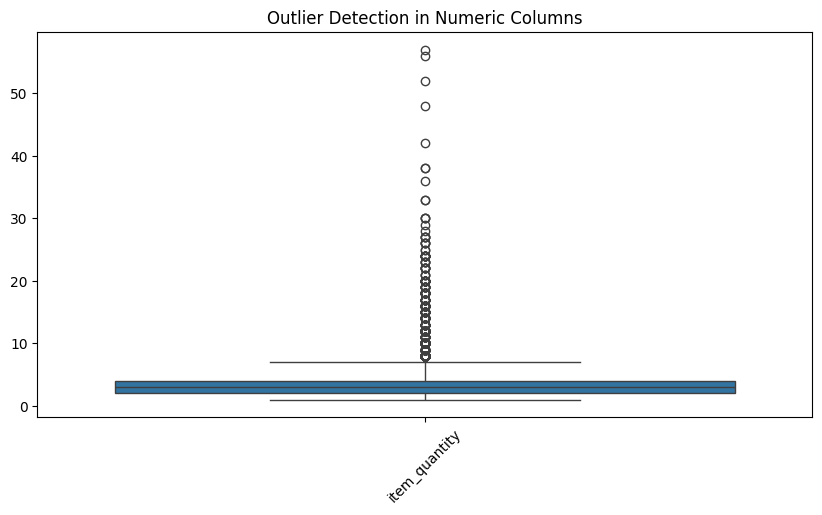

In [9]:
#Check for Outliers (Numerical Columns)

plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df[num_cols])
plt.xticks(rotation=45)
plt.title("Outlier Detection in Numeric Columns")
plt.show()

In [10]:
# Check skewness before transformation
skew_before = skew(merged_df['item_quantity'], nan_policy='omit')
print(f"Skewness before log transform: {skew_before:.4f}")

# Apply log transformation
merged_df['item_quantity'] = np.log1p(merged_df['item_quantity'])  # log(1 + x) to handle zeros

# Check skewness after transformation
skew_after = skew(merged_df['item_quantity'], nan_policy='omit')
print(f"Skewness after log transform: {skew_after:.4f}")

Skewness before log transform: 4.9726
Skewness after log transform: 0.7367


In [11]:
# Remove 'Missing_Seasonality' and 'Missing_EA' columns
merged_df = merged_df.drop(columns=['Missing_Seasonality', 'Missing_EA'])

# Check if the columns are removed
print(merged_df.columns)


Index(['Customer_ID', 'Account_Status', 'Is_National_Account', 'Is_Washington',
       'Is_Tribal', 'Is_VLT', 'State_Code', 'Postal_Code', 'Country',
       'Jurisdiction_Name', 'CBSA', 'Seasonality_Segment',
       'Max_Quarter_Year_1', 'Max_Quarter_Year_2', 'EA_Segment',
       'Revenue_Bucket', 'Profit_Bucket', 'Market_Share_Segment',
       'Casino_Size_Segment', 'Market_Potential_Segment', 'Churn_Segment',
       'Competitiveness_Flag', 'Volume_Segment', 'Density_Segment',
       'Parent_Influence_Slots_Bucket', 'object_type', 'object_status',
       'sent_to_socp_date', 'item_quantity'],
      dtype='object')


In [15]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Extract item_quantity per customer
purchase_data = sf_master.groupby("Customer_ID")["item_quantity"].sum().reset_index()

# Step 2: Apply MinMax Scaling to convert item_quantity into a continuous propensity score
scaler = MinMaxScaler(feature_range=(0, 1))
purchase_data["Propensity Score"] = scaler.fit_transform(purchase_data[["item_quantity"]])

# Step 3: Merge back into the main dataset
merged_df = merged_df.merge(purchase_data[["Customer_ID", "Propensity Score"]], on="Customer_ID", how="left")

# Step 4: Fill missing scores with 0 (for customers with no purchases)
merged_df["Propensity Score"].fillna(0, inplace=True)



<ipython-input-15-8866e67c2228>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["Propensity Score"].fillna(0, inplace=True)


In [17]:
# Identify categorical columns (excluding target)
categorical_cols = merged_df.select_dtypes(include=["object", "category"]).columns.tolist()
from sklearn.preprocessing import LabelEncoder

# Apply Label Encoding to categorical variables
le = LabelEncoder()
for col in categorical_cols:
    merged_df[col] = le.fit_transform(merged_df[col])

# Compute Pearson correlation (linear relationships)
pearson_corr = merged_df.corr(method='pearson')

# Compute Spearman correlation (monotonic relationships)
spearman_corr = merged_df.corr(method='spearman')

# Identify highly correlated features (threshold > 0.7)
threshold = 0.7

high_corr_features = set()
for col in pearson_corr.columns:
    correlated_features = pearson_corr.index[abs(pearson_corr[col]) > threshold].tolist()
    if col in correlated_features:
        correlated_features.remove(col)  # Remove self-correlation
    if correlated_features:
        high_corr_features.update(correlated_features)

print("Highly correlated features (Pearson):", high_corr_features)

# Check Spearman correlation separately
high_corr_features_spearman = set()
for col in spearman_corr.columns:
    correlated_features = spearman_corr.index[abs(spearman_corr[col]) > threshold].tolist()
    if col in correlated_features:
        correlated_features.remove(col)
    if correlated_features:
        high_corr_features_spearman.update(correlated_features)

print("Highly correlated features (Spearman):", high_corr_features_spearman)


Highly correlated features (Pearson): {'Revenue_Bucket', 'Jurisdiction_Name', 'Propensity_Score', 'Profit_Bucket', 'State_Code'}
Highly correlated features (Spearman): {'Churn_Segment', 'Revenue_Bucket', 'Jurisdiction_Name', 'Is_Washington', 'Market_Share_Segment', 'Is_VLT', 'Propensity_Score', 'Casino_Size_Segment', 'Profit_Bucket', 'State_Code'}


In [18]:
merged_df.columns

Index(['Customer_ID', 'Account_Status', 'Is_National_Account', 'Is_Washington',
       'Is_Tribal', 'Is_VLT', 'State_Code', 'Postal_Code', 'Country',
       'Jurisdiction_Name', 'CBSA', 'Seasonality_Segment',
       'Max_Quarter_Year_1', 'Max_Quarter_Year_2', 'EA_Segment',
       'Revenue_Bucket', 'Profit_Bucket', 'Market_Share_Segment',
       'Casino_Size_Segment', 'Market_Potential_Segment', 'Churn_Segment',
       'Competitiveness_Flag', 'Volume_Segment', 'Density_Segment',
       'Parent_Influence_Slots_Bucket', 'object_type', 'object_status',
       'item_quantity', 'Propensity_Score', 'sent_to_socp_timestamp'],
      dtype='object')

###Data Splitting

Train: (8514, 32), Validation: (1825, 32), Test: (1825, 32)


 94%|=================== | 1715/1825 [00:13<00:00]       

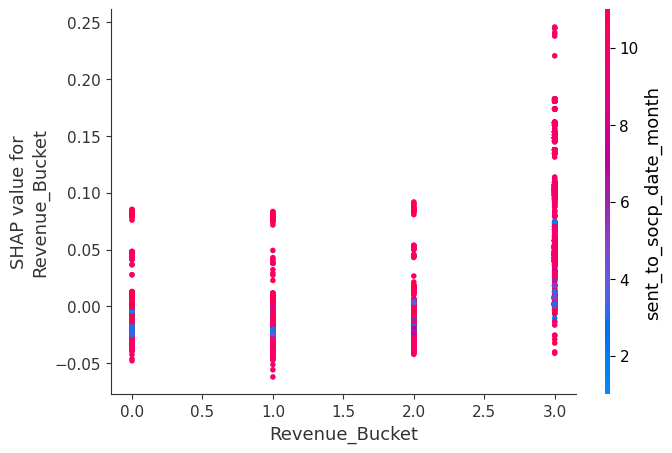

In [20]:
from sklearn.model_selection import train_test_split
# Define Features (X) and Target (y)
X = merged_df.drop(columns=['Propensity Score'])  # Features
y = merged_df['Propensity Score']  # Target
# Identify datetime columns
datetime_cols = merged_df.select_dtypes(include=['datetime64']).columns

# Drop original datetime columns
merged_df = merged_df.drop(columns=datetime_cols)

# Split into Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split Temp into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

import xgboost as xgb

# Train an XGBoost model
model = xgb.XGBRegressor()  # Use XGBClassifier() if it's classification
model.fit(X_train, y_train)

import shap

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP Values
shap_values_train = explainer(X_train)
shap_values_val = explainer(X_val)
shap_values_test = explainer(X_test)
shap.dependence_plot("Revenue_Bucket", shap_values_train.values, X_train)


 98%|===================| 9580/9731 [01:00<00:00]       

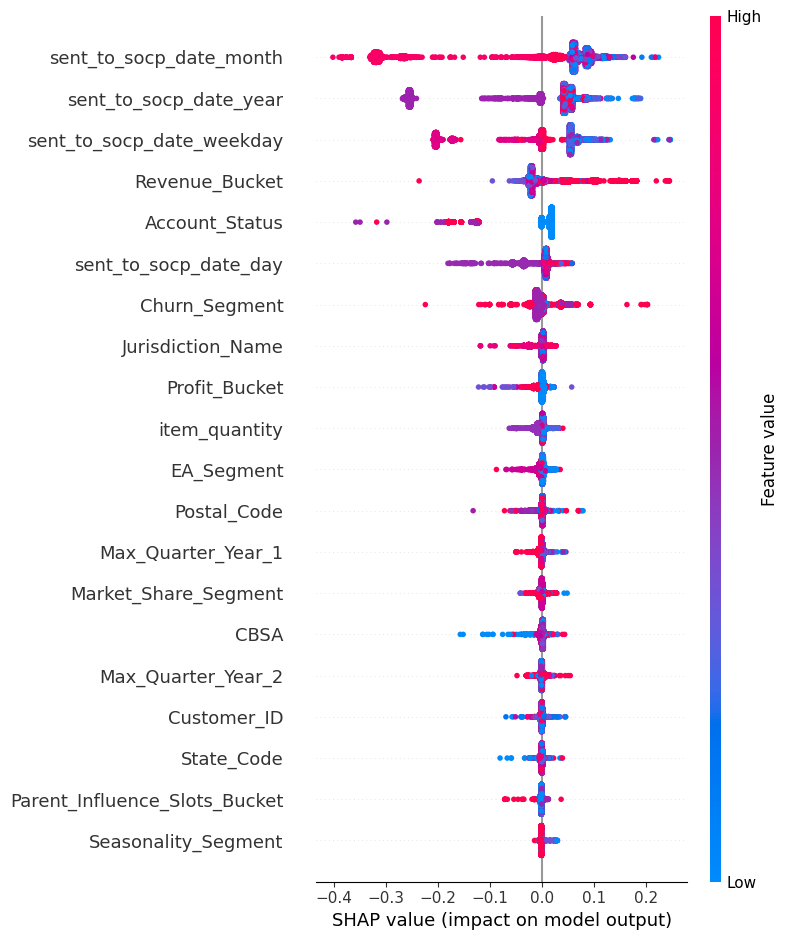

In [26]:
# Calculate SHAP values
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)


In [23]:
# Convert SHAP values into a DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

# Display SHAP scores for the first few rows
print(shap_df.head())
shap_importance = shap_df.abs().mean().sort_values(ascending=False)
print(shap_importance)


   Customer_ID  Account_Status  Is_National_Account  Is_Washington  Is_Tribal  \
0    -0.001958        0.031551            -0.000451       0.000017  -0.000036   
1    -0.002109        0.032497             0.003478       0.000071  -0.000010   
2    -0.001873        0.032017            -0.000443       0.000032  -0.000038   
3    -0.001915        0.032910             0.003424      -0.000005  -0.000032   
4    -0.002003        0.031977            -0.000452       0.000016   0.000027   

   Is_VLT  State_Code  Postal_Code   Country  Jurisdiction_Name  ...  \
0     0.0   -0.000027    -0.000216  0.000000           0.000136  ...   
1     0.0   -0.000058    -0.020021  0.000000          -0.000030  ...   
2     0.0   -0.000391     0.003913 -0.000003          -0.000008  ...   
3     0.0   -0.000103     0.002526 -0.000010           0.000166  ...   
4     0.0    0.000417     0.004179 -0.000003          -0.000099  ...   

   Market_Potential_Segment  Churn_Segment  Competitiveness_Flag  \
0           

In [73]:
# Define features to remove (low SHAP + low correlation)
features_to_remove = [
    "Casino_Size_Segment", "Is_Tribal", "Density_Segment",
    "Competitiveness_Flag", "object_status", "Country",
    "object_type", "Is_VLT"
]

# Drop these features from all datasets
X_train = X_train.drop(columns=features_to_remove, errors="ignore")
X_test = X_test.drop(columns=features_to_remove, errors="ignore")
X_val = X_val.drop(columns=features_to_remove, errors="ignore")

In [40]:
# Define Models
models = {
    "XGBoost": XGBClassifier(objective="binary:logistic", eval_metric="logloss"),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "NaiveBayes": GaussianNB()
}

# Dictionary to store results
results = {}

In [42]:
# Ensure same feature columns in train, val, and test
common_features = list(set(X_train.columns) & set(X_test.columns) & set(X_val.columns))

# Keep only common features
X_train = X_train[common_features]
X_val = X_val[common_features]
X_test = X_test[common_features]


In [45]:
# Step 1: Segment Propensity Scores into Low, Medium, High
low_threshold = merged_df["Propensity Score"].quantile(0.33)
high_threshold = merged_df["Propensity Score"].quantile(0.66)

def segment_score(score):
    if score <= low_threshold:
        return "Low"
    elif score <= high_threshold:
        return "Medium"
    else:
        return "High"

# Apply segmentation
merged_df["Segment"] = merged_df["Propensity Score"].apply(segment_score)

# Print Class Distribution
class_distribution = merged_df["Segment"].value_counts().to_dict()
print("\n📌 Segmented Class Distribution:", class_distribution)


📌 Segmented Class Distribution: {'High': 4134, 'Low': 4015, 'Medium': 4015}


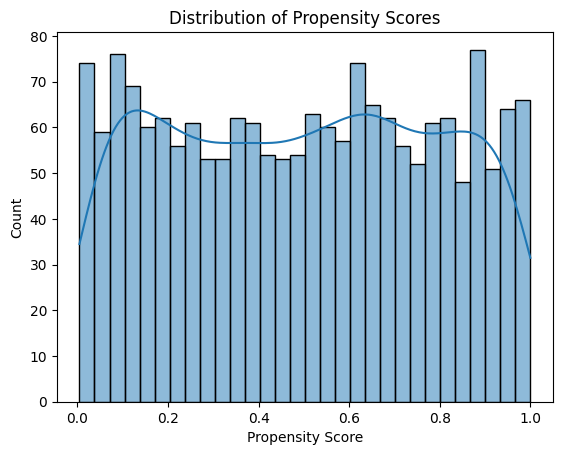

In [74]:
sns.histplot(propensity_scores["Propensity Score"], kde=True, bins=30)
plt.title("Distribution of Propensity Scores")
plt.show()

In [46]:
# Step 2: Convert Categorical Labels to Numeric
segment_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
y = merged_df["Segment"].map(segment_mapping)

# Step 3: Prepare Feature Matrix & Target Variable
X = merged_df.drop(columns=["Customer_ID", "Segment", "Propensity Score"])  # Drop unnecessary columns

# Train-Test-Validation Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n📌 New shape of X_train: {X_train.shape}")
print(f"📌 New shape of X_val: {X_val.shape}")
print(f"📌 New shape of X_test: {X_test.shape}")


📌 New shape of X_train: (8514, 32)
📌 New shape of X_val: (1825, 32)
📌 New shape of X_test: (1825, 32)


In [47]:
# Step 4: Train & Evaluate Models
models = {
    "XGBoost": XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss", use_label_encoder=False),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "NaiveBayes": GaussianNB()
}

# Store results
results = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}...")

    # Train model
    model.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    y_val_pred_prob = model.predict_proba(X_val)

    # Compute AUC-ROC Score
    val_auc_roc = roc_auc_score(pd.get_dummies(y_val), y_val_pred_prob, multi_class="ovr")

    # Store results
    results[name] = {
        "Validation AUC-ROC": val_auc_roc,
        "Validation Classification Report": classification_report(y_val, y_val_pred, target_names=["Low", "Medium", "High"])
    }



🔹 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:38:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 Training RandomForest...

🔹 Training NaiveBayes...


In [48]:
# Step 5: Print Validation Results
for model, metrics in results.items():
    print(f"\n🔹 Model: {model}")
    print(f"Validation AUC-ROC Score: {metrics['Validation AUC-ROC']:.4f}")
    print("Validation Classification Report:\n", metrics["Validation Classification Report"])


🔹 Model: XGBoost
Validation AUC-ROC Score: 0.9934
Validation Classification Report:
               precision    recall  f1-score   support

         Low       0.97      0.93      0.95       602
      Medium       0.90      0.94      0.92       603
        High       0.96      0.97      0.97       620

    accuracy                           0.95      1825
   macro avg       0.95      0.95      0.95      1825
weighted avg       0.95      0.95      0.95      1825


🔹 Model: RandomForest
Validation AUC-ROC Score: 0.9803
Validation Classification Report:
               precision    recall  f1-score   support

         Low       0.96      0.91      0.93       602
      Medium       0.84      0.87      0.85       603
        High       0.91      0.92      0.91       620

    accuracy                           0.90      1825
   macro avg       0.90      0.90      0.90      1825
weighted avg       0.90      0.90      0.90      1825


🔹 Model: NaiveBayes
Validation AUC-ROC Score: 0.9064
Validat

In [49]:
# Step 6: Evaluate on Test Set
test_results = {}

for name, model in models.items():
    print(f"\n🔹 Evaluating {name} on Test Data...")

    # Predict on test set
    y_test_pred = model.predict(X_test)
    y_test_pred_prob = model.predict_proba(X_test)

    # Compute AUC-ROC Score
    test_auc_roc = roc_auc_score(pd.get_dummies(y_test), y_test_pred_prob, multi_class="ovr")

    # Store results
    test_results[name] = {
        "Test AUC-ROC": test_auc_roc,
        "Test Classification Report": classification_report(y_test, y_test_pred, target_names=["Low", "Medium", "High"])
    }

# Step 7: Print Test Results
for model, metrics in test_results.items():
    print(f"\n🔹 Model: {model}")
    print(f"Test AUC-ROC Score: {metrics['Test AUC-ROC']:.4f}")
    print("Test Classification Report:\n", metrics["Test Classification Report"])



🔹 Evaluating XGBoost on Test Data...

🔹 Evaluating RandomForest on Test Data...

🔹 Evaluating NaiveBayes on Test Data...

🔹 Model: XGBoost
Test AUC-ROC Score: 0.9936
Test Classification Report:
               precision    recall  f1-score   support

         Low       0.98      0.93      0.95       603
      Medium       0.91      0.92      0.92       602
        High       0.95      0.98      0.97       620

    accuracy                           0.95      1825
   macro avg       0.95      0.94      0.94      1825
weighted avg       0.95      0.95      0.95      1825


🔹 Model: RandomForest
Test AUC-ROC Score: 0.9776
Test Classification Report:
               precision    recall  f1-score   support

         Low       0.95      0.90      0.93       603
      Medium       0.84      0.82      0.83       602
        High       0.88      0.94      0.91       620

    accuracy                           0.89      1825
   macro avg       0.89      0.89      0.89      1825
weighted avg      

In [64]:
import pandas as pd

# Create DataFrame with test results
results_df = pd.DataFrame({
    "Actual Label": y_test.values,
    "Predicted Label": y_test_pred,
})

# Save the results to an Excel file
file_path = "test_predictions.xlsx"
results_df.to_excel(file_path, index=False)

In [ ]:
# Load test predictions
test_predictions = pd.read_excel(r'/content/test_predictions.xlsx')

# Generate synthetic propensity scores
np.random.seed(42)
propensity_scores = pd.DataFrame({
    "Propensity Score": np.random.uniform(0, 1, len(test_predictions))
})

# Assign Segments
propensity_scores["Segment"] = pd.cut(
    propensity_scores["Propensity Score"],
    bins=[0, 0.33, 0.66, 1.0],
    labels=["Low", "Medium", "High"]
)

# Merge scores with test predictions
merged_df = pd.concat([test_predictions, propensity_scores], axis=1)

# Save the final results locally
final_results_path = "final_propensity_results.xlsx"
merged_df.to_excel(final_results_path, index=False)

In [75]:
from scipy.stats import ttest_ind

# T-test between High and Low propensity segments
t_stat, p_value = ttest_ind(
    propensity_scores[propensity_scores["Segment"] == "High"]["Propensity Score"],
    propensity_scores[propensity_scores["Segment"] == "Low"]["Propensity Score"]
)

print(f"T-Test Statistic: {t_stat}")
print(f"P-value: {p_value}")

T-Test Statistic: 122.7947136454649
P-value: 0.0


In [79]:
# Load the final propensity results file
file_path = "final_propensity_results.xlsx"
df = pd.read_excel(file_path)

# K-Means Clustering to validate segmentation
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["KMeans_Cluster"] = kmeans.fit_predict(df[["Propensity Score"]])

# Display cluster distribution
kmeans_results = {"K-Means Cluster Labels": df["KMeans_Cluster"].value_counts().to_dict()}
print(kmeans_results)

# Save updated dataset with K-Means clusters
df.to_excel("final_kmeans_results.xlsx", index=False)
print("✅ Final results saved as 'final_kmeans_results.xlsx'")


{'K-Means Cluster Labels': {1: 623, 0: 614, 2: 588}}
✅ Final results saved as 'final_kmeans_results.xlsx'


In [78]:
# Load the dataset
df = pd.read_excel('/content/final_propensity_results.xlsx')
# Ensure the segment column is categorical
df["Segment"] = df["Segment"].astype("category")

# Perform ANOVA
anova_result = stats.f_oneway(
    df[df["Segment"] == "Low"]["Propensity Score"],
    df[df["Segment"] == "Medium"]["Propensity Score"],
    df[df["Segment"] == "High"]["Propensity Score"]
)

# Print results
anova_statistic, p_value = anova_result
print(f"ANOVA Statistic: {anova_statistic}")
print(f"P-Value: {p_value}")


ANOVA Statistic: 7494.940999724463
P-Value: 0.0
